In [ ]:
#Data source: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data
#data exploration:

In [1]:
import pandas as pd
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

df = pd.read_csv('dataset/PRSA_data_2010.1.1-2014.12.31.csv')
print(list(df))  # See a list of variables in this table
print(df.head(20))  # Print the first 20 rows
print(len(df))

['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']
    No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0    1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1    2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2    3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3    4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4    5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0
5    6  2010      1    1     5    NaN   -19 -10.0  1017.0   NW  16.10   0   0
6    7  2010      1    1     6    NaN   -19  -9.0  1017.0   NW  19.23   0   0
7    8  2010      1    1     7    NaN   -19  -9.0  1017.0   NW  21.02   0   0
8    9  2010      1    1     8    NaN   -19  -9.0  1017.0   NW  24.15   0   0
9   10  2010      1    1     9    NaN   -20  -8.0  1017.0   NW  27.28   0   0
10  11  2010      1    1    10    NaN   -19

In [2]:
#There are some missing values in the pm2.5 column ('NaN'). Let's clean the missing data from the table:

df_clean = df[~df['pm2.5'].isin(['NaN'])]
print(len(df_clean))
print(df_clean.head(20))

41757
    No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
24  25  2010      1    2     0  129.0   -16  -4.0  1020.0   SE   1.79   0   0
25  26  2010      1    2     1  148.0   -15  -4.0  1020.0   SE   2.68   0   0
26  27  2010      1    2     2  159.0   -11  -5.0  1021.0   SE   3.57   0   0
27  28  2010      1    2     3  181.0    -7  -5.0  1022.0   SE   5.36   1   0
28  29  2010      1    2     4  138.0    -7  -5.0  1022.0   SE   6.25   2   0
29  30  2010      1    2     5  109.0    -7  -6.0  1022.0   SE   7.14   3   0
30  31  2010      1    2     6  105.0    -7  -6.0  1023.0   SE   8.93   4   0
31  32  2010      1    2     7  124.0    -7  -5.0  1024.0   SE  10.72   0   0
32  33  2010      1    2     8  120.0    -8  -6.0  1024.0   SE  12.51   0   0
33  34  2010      1    2     9  132.0    -7  -5.0  1025.0   SE  14.30   0   0
34  35  2010      1    2    10  140.0    -7  -5.0  1026.0   SE  17.43   1   0
35  36  2010      1    2    11  152.0    -8  -5.0  1026.0 

count    41757.000000
mean        98.613215
std         92.050387
min          0.000000
25%         29.000000
50%         72.000000
75%        137.000000
max        994.000000
Name: pm2.5, dtype: float64


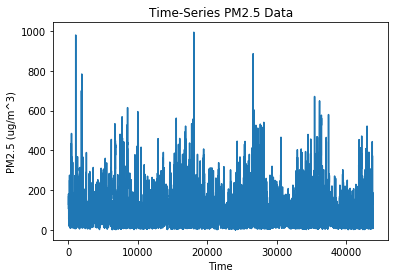

In [30]:
df_univariate = df_clean['pm2.5']
print(df_univariate.describe())
df_univariate.plot()
pyplot.xlabel('Time')
pyplot.ylabel('PM2.5 (ug/m^3)')
pyplot.title('Time-Series PM2.5 Data')
pyplot.show()

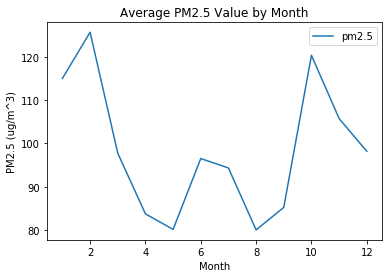

            pm2.5
month            
1      115.059061
2      125.736140
3       97.757593
4       83.709251
5       80.113051
6       96.513656
7       94.332328
8       79.996704
9       85.209421
10     120.401509
11     105.762639
12      98.200226


In [31]:
#It looks like peaks occur annually. Let's explore the data grouped by month:

df_months = df_clean[['month', 'pm2.5']]
month_avg = df_months.groupby(['month']).agg(np.mean)

month_avg.plot()
pyplot.xlabel('Month')
pyplot.ylabel('PM2.5 (ug/m^3)')
pyplot.title('Average PM2.5 Value by Month')
pyplot.show()
print(month_avg)

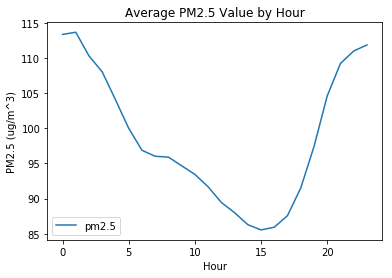

           pm2.5
hour            
0     113.390202
1     113.698567
2     110.323174
3     108.042980
4     104.080275
5     100.013218
6      96.882759
7      96.024727
8      95.907940
9      94.672800
10     93.447520
11     91.678633
12     89.448873
13     87.990280
14     86.283247
15     85.534215
16     85.922280
17     87.571183
18     91.507710
19     97.398393
20    104.614368
21    109.249856
22    111.021252
23    111.889782


In [32]:
#And let's see if there are any patterns throughout a day, here's the data grouped by hour:

df_hours = df_clean[['hour', 'pm2.5']]
hours_avg = df_hours.groupby(['hour']).agg(np.mean)

hours_avg.plot()
pyplot.xlabel('Hour')
pyplot.ylabel('PM2.5 (ug/m^3)')
pyplot.title('Average PM2.5 Value by Hour')
pyplot.show()
print(hours_avg)

In [ ]:
# arima prediction model for a time series:
# Original Script by Jason Brownlee:
# https://machinelearningmastery.com/make-manual-predictions-arima-models-python/

In [27]:
def predict(coef, history):
	yhat = 0.0
	for i in range(1, len(coef)+1):
		yhat += coef[i-1] * history[-i]
	return yhat
 
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return np.array(diff)
 
df_pm = df_clean[['pm2.5']]
    
X = df_pm.values # get all the pollution values
size = len(X)-100 # predict last 100 hours
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
predicted = []
expected = []
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,1))
	model_fit = model.fit(trend='nc', disp=False)
	ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
	resid = model_fit.resid
	diff = difference(history)
	yhat = history[-1] + predict(ar_coef, diff) + predict(ma_coef, resid)
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('>predicted=%.3f, expected=%.3f' % (yhat, obs))
	pred_list=yhat.tolist() #turn the arrays into lists
	exp_list=obs.tolist()
	predicted.append(pred_list[0]) #compile lists of predicted and expected values for graphing
	expected.append(exp_list[0])
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

 

Test RMSE: 33.037


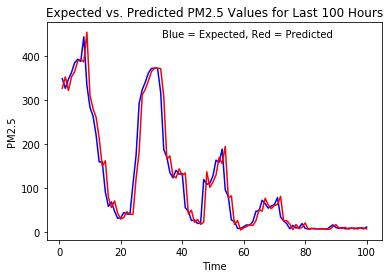

In [38]:
#print(expected)
#print(predicted)
x_range = np.arange(1, len(expected)+1, 1)
pyplot.plot(x_range, expected, 'b-', x_range, predicted, 'r-')
pyplot.xlabel('Time')
pyplot.ylabel('PM2.5')
pyplot.title('Expected vs. Predicted PM2.5 Values for Last 100 Hours')
pyplot.text(len(expected)/3, max(expected)-1, 'Blue = Expected, Red = Predicted')
pyplot.show()


In [21]:
#Here's some other interesting plots using the averaging technique: 

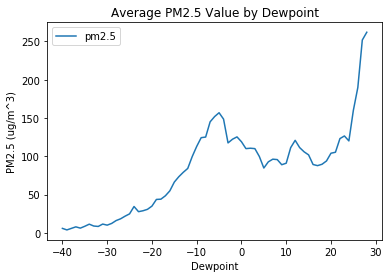

In [33]:
df_dewp = df_clean[['DEWP', 'pm2.5']]
dewp_avg = df_dewp.groupby(['DEWP']).agg(np.mean)

dewp_avg.plot()
pyplot.xlabel('Dewpoint')
pyplot.ylabel('PM2.5 (ug/m^3)')
pyplot.title('Average PM2.5 Value by Dewpoint')
pyplot.show()

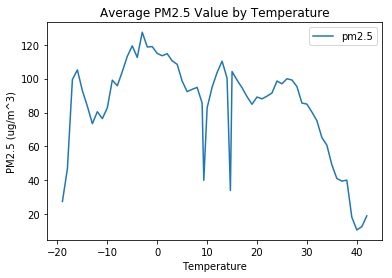

In [34]:
df_temp = df_clean[['TEMP', 'pm2.5']]
temp_avg = df_temp.groupby(['TEMP']).agg(np.mean)

temp_avg.plot()
pyplot.xlabel('Temperature')
pyplot.ylabel('PM2.5 (ug/m^3)')
pyplot.title('Average PM2.5 Value by Temperature')
pyplot.show()

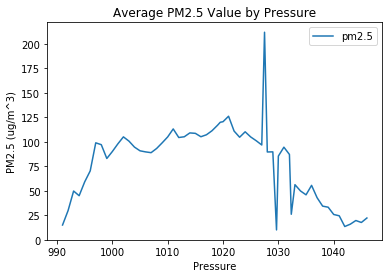

In [36]:
df_pres = df_clean[['PRES', 'pm2.5']]
pres_avg = df_pres.groupby(['PRES']).agg(np.mean)

pres_avg.plot()
pyplot.xlabel('Pressure')
pyplot.ylabel('PM2.5 (ug/m^3)')
pyplot.title('Average PM2.5 Value by Pressure')
pyplot.show()

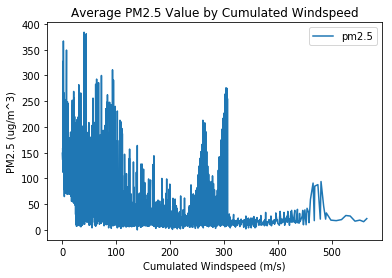

In [35]:
df_Iws = df_clean[['Iws', 'pm2.5']]
Iws_avg = df_Iws.groupby(['Iws']).agg(np.mean)

Iws_avg.plot()
pyplot.xlabel('Cumulated Windspeed (m/s)')
pyplot.ylabel('PM2.5 (ug/m^3)')
pyplot.title('Average PM2.5 Value by Cumulated Windspeed')
pyplot.show()